In [1]:
from setup_notebook import set_css_style

import cv2
import os

import tensorflow as tf

from matplotlib import pyplot as plt

set_css_style()

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Object detection - the little walkthrough

## Haar cascades

The pre-trained model can be found in the OpenCV repo itself, at https://github.com/opencv/opencv/tree/master/data/haarcascades

In [2]:
!ls ../

code                                haarcascade_frontalface_default.xml
foto_martina.jpg                    slides.pdf


78 84 98 98


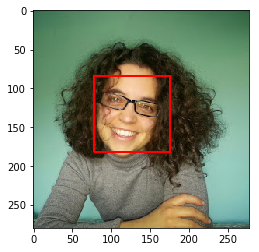

In [3]:
# Read image: we'll use my beautiful face ... (transform into RGB as OpenCV reads in BGR)
image = cv2.imread('../foto_martina.jpg')
RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Transform image in grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# use the trained model for frontal face
# have to pass path to where model is stored
face_cascade = cv2.CascadeClassifier('../haarcascade_frontalface_default.xml')

# detect my face and where it is (draw ROI around it), detection is on the grayscale one
objects = face_cascade.detectMultiScale(image_gray, scaleFactor=1.3, minNeighbors=5)
for (x,y,w,h) in objects:
    print(x,y,w,h)
    cv2.rectangle(RGB_image, (x,y), (x+w,y+h), (255, 0, 0), 2)
        
plt.imshow(RGB_image)
#plt.grid()
plt.show();

## Yolo

1. Clone the repo from https://github.com/pjreddie/darknet
2. Compile it - edit the Makefile to tell it to compile for GPU use
3. Fetch some pre-trained weights from https://pjreddie.com/darknet/ - I used those for YOLOv3, trained on the [COCO dataset](http://cocodataset.org/#home) ([80 classes](https://github.com/pjreddie/darknet/blob/master/data/coco.names))
4. The repo comes with some nets configurations already so you can use them already
5. You can then run this command to detect objects in that set, on your image:

`./darknet detector test <cfg data file> <cfg file> <weights> <img>`

* the `cfg data file` specifies the metadata needed to run the model, like the list of class names and where to store weights
* the configuration file (also in the same folder in the repo) is the meat of the architecture instead

This will create an image with the predicted bounding boxes.

In [4]:
# example

# ./darknet detector test cfg/coco.data cfg/yolov3.cfg yolov3.weights data/my-pic.jpg

## Annotating images to create a training set

You can use this neat tool at https://github.com/tzutalin/labelImg

## TensorFlow - a brief journey

In [5]:
tf.__version__

'1.10.1'

### Components

* `tf.Graph`: the computational program, made of `tf.Tensor` and `tf.Operation` objects - it is where tensors "flow"
* `tf.Session`: the runtime, runs the graph by running its operations (`tf.Session.run()`)
* *operations* manipulate tensors
* `tf.Tensor` the tensor object

Graph and Session are the main componenents of TF Core.

### Tensors

A fancy name for a multi-dimensional array. A tensor has a given shape and relates to data of a given type. Data types include string, int, float, etc. A tensor's rank is its number of dimensions. A tensor is evaluated in a session.

#### Pre-existing tensors

These are special classes for tensor that exist.

* `tf.constant`: tensor containing constants, can be numbers or arrays but they don't get to change - correspond to a Const node in the graph
* `tf.Variable`: a variable tensor, that is, it can change via operations in the graph. A variable tensor exists outside of the session it is run into
* `tf.placeholder`: a placeholder acting like a promise to get some values later 
* others (...)

### Operations

* Each operation in a graph has a name, this can be given when creating the operation or gets default value from the API

### Play with tensors

In [6]:
# Define some tensors for numbers
a = tf.constant(3, dtype=tf.int32)
b = tf.constant(4)       # this will infer the type as int, if you put value "4.0" will infer type as float
c = tf.constant(5, dtype=tf.float32)
d = tf.constant(1.0)
e = tf.constant([1, 2], name='e')
f = tf.constant([[1, 2], [0, 1]], name='f')

a, b, b.dtype, d.dtype, c.dtype, c.name, a.name, e.name, f.name, tf.rank(f)

(<tf.Tensor 'Const:0' shape=() dtype=int32>,
 <tf.Tensor 'Const_1:0' shape=() dtype=int32>,
 tf.int32,
 tf.float32,
 tf.float32,
 'Const_2:0',
 'Const:0',
 'e:0',
 'f:0',
 <tf.Tensor 'Rank:0' shape=() dtype=int32>)

In [7]:
# summing them - returns a tensor
tot = a + b

type(tot)
tot
tot.dtype, tot.shape, tf.rank(tot), tot.name  # rank is 0 as it's a number

(tf.int32,
 TensorShape([]),
 <tf.Tensor 'Rank_1:0' shape=() dtype=int32>,
 'add:0')

In [8]:
# evaluate the result - you need a session

sess = tf.Session()
sess.run(tot)

7

In [9]:
# you can also add tensors like

tot2 = tf.add(a, b, name='add_op')   # name the operation, will appear in the graph
sess.run(tot2)

7

## Training a small model

You need to add each element one by one. This example is adapted from the tutorial listed in the refs, it trains a linear regression. To do it we'll use

* A `tf.layers.Dense` as the linear model as it has a linear activation per default (differnet activations can be set)

We will create a graph for it rather than using the default one, it is run for TB below so can be visualised. 

In [10]:
# create the graph
g = tf.Graph()

with g.as_default():

    # x and y training data, as matrices of single-number arrays
    X = [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]
    Y = [[0], [-1], [-2], [-3], [-4], [-5], [-6], [-7], [-8], [-9]]
    x = tf.constant(X, dtype=tf.float32)
    y_true = tf.constant(Y, dtype=tf.float32)

    # Using a Dense layer as the linear model
    linear_model = tf.layers.Dense(units=1)

    # Define the operation (set of as it's a layer) to run model for prediction
    y_pred = linear_model(x)

    # Define the loss as a MSE
    loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)

    # Define a GD as optimizer with chosen learning rate, and the operation to train
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)
    for i in range(100):
      _, loss_value = sess.run((train, loss))
      #print(loss_value)

    plt_y_pred = sess.run(y_pred)
    print(plt_y_pred)

[[-0.7588539]
 [-1.6315684]
 [-2.5042827]
 [-3.3769972]
 [-4.2497115]
 [-5.122426 ]
 [-5.9951406]
 [-6.867855 ]
 [-7.7405696]
 [-8.613284 ]]


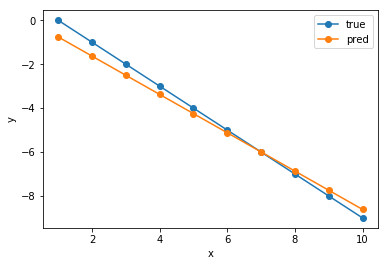

In [11]:
# plotting it

plt_x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt_y_true = [0, -1, -2, -3, -4, -5, -6, -7, -8, -9]


plt.plot(plt_x, plt_y_true, marker='o', label='true')
plt.plot(plt_x, plt_y_pred, marker='o', label='pred')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show();

## Estimators

* Estimators in TF are classed as high-level API. 
* Estimators are full models that you can train and evaluate, then use for predictions. 
* They're useful so all the logging and low-level preparation of the objects that go into building your models are handled for you. 
* There are some pre-made ones, like a linear regressor

### Input functions

Input functions are functions to create a `tf.data.Dataset` object to contain features (as dictionary) and labels (as array). An simple input function is for instance (for an IRIS dataset classification):

```py
def input_evaluation_set():
    features = {'SepalLength': np.array([6.4, 5.0]),
                'SepalWidth':  np.array([2.8, 2.3]),
                'PetalLength': np.array([5.6, 3.3]),
                'PetalWidth':  np.array([2.2, 1.0])}
    labels = np.array([2, 1])
    return features, labels
```

## Resources

* [Intro to the low-level API, from Tensorflow official](https://www.tensorflow.org/guide/low_level_intro)
* Some parts on Tensorboard has been derived from the [Dev Summit 2017 video](https://www.tensorflow.org/guide/summaries_and_tensorboard) they have on the official TF page
* On [tensors](https://www.tensorflow.org/guide/tensors), on [graphs and sessions](https://www.tensorflow.org/guide/graphs)
* On using devices and [GPUs specifically](https://www.tensorflow.org/guide/using_gpu)
* On the [Keras TF API](https://www.tensorflow.org/guide/keras)
* On [TF Estimators](https://www.tensorflow.org/guide/premade_estimators) and especially on how to build a custom one, an [example](https://github.com/tensorflow/models/blob/master/samples/core/get_started/custom_estimator.py)
* Walkthrough of the MNIST [example](https://jhui.github.io/2017/03/12/TensorBoard-visualize-your-learning/)
* On [Protocol Buffers](https://developers.google.com/protocol-buffers/?hl=en)
* This [blog](https://towardsdatascience.com/how-to-train-your-own-object-detector-with-tensorflows-object-detector-api-bec72ecfe1d9) gives a fill walkthrough of all it's needed to train a network for object detection in TensorFlow, from creating the dataset to launching and evaluating the job